In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf

# -------------------------
# Paths
# -------------------------
DATA_PATH = "../data/mdm2_data_files/big_table_with_weather_and_rain_with_geo_clusters_v2.csv"

FIG_DIR = "../figures"
REP_DIR = "../reports"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(REP_DIR, exist_ok=True)

OUT_RESULTS_CSV = os.path.join(REP_DIR, "combined_nb_clustered_results.csv")

# -------------------------
# Load + basic cleaning
# -------------------------
df = pd.read_csv(DATA_PATH)

# Required columns sanity
required = ["ped","cyc","sensor_id","datetime","hour","dow","month","Dark","temp_c","wind_ms","rain_mm","cluster_geo"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}\nColumns present: {df.columns.tolist()}")

# Ensure types
df["hour"] = df["hour"].astype(int)
df["dow"] = df["dow"].astype(int)
df["month"] = df["month"].astype(int)
df["cluster_geo"] = df["cluster_geo"].astype(int)

# datetime
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", utc=True)
df = df.dropna(subset=["datetime"])

# outcome: combined active non-motorised
df["active"] = df["ped"].fillna(0) + df["cyc"].fillna(0)
df = df[df["active"].notna()]

# Drop any negative counts (just in case)
df = df[(df["active"] >= 0) & (df["ped"] >= 0) & (df["cyc"] >= 0)]

# Fill weather gaps lightly (tiny missing rates are fine)
for col in ["temp_c","wind_ms","rain_mm"]:
    if df[col].isna().any():
        df[col] = df[col].interpolate(limit=6).fillna(df[col].median())


print("Loaded:", df.shape)
print("Date range:", df["datetime"].min(), "to", df["datetime"].max())
print("Clusters:", sorted(df["cluster_geo"].unique()))
print("Mean active:", df["active"].mean(), " | % zero:", (df["active"]==0).mean())

# -------------------------
# Model specification (NB GLM)
# -------------------------
# - main effects: cluster, hour, dow, month, weather, rain
# - interactions: Dark×cluster (core: does darkness differ by area?)
#                 Dark×rain (people avoid dark+raining more?)
#                 Dark×hour (darkness effect differs in evening vs night)
#
# Notes:
# - We treat hour/dow/month as categorical (captures seasonality + commute pattern).
# - Cluster-robust SE clustered by sensor_id (accounts for repeated measures per sensor).
#
formula = """
active ~
    C(cluster_geo) + C(hour) + C(dow) + C(month)
    + temp_c + wind_ms + rain_mm
    + Dark
    + Dark:C(cluster_geo)
    + Dark:rain_mm
    + Dark:C(hour)
"""

print("\nFitting Negative Binomial GLM (cluster-robust SE by sensor_id)...\n")
model = smf.glm(formula=formula, data=df, family=sm.families.NegativeBinomial()).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["sensor_id"]}
)

print(model.summary())

# -------------------------
# Dispersion (diagnostic)
# -------------------------
# For GLM output, Pearson chi2 / df_resid is a common dispersion diagnostic.
dispersion = model.pearson_chi2 / model.df_resid
print("\n" + "="*90)
print(f"Dispersion statistic (Pearson chi2 / df_resid): {dispersion:.3f}")
print("="*90)

# -------------------------
# Darkness effect per cluster (model-based)
# -------------------------
# Baseline (cluster 0): effect = exp(beta_Dark) - 1
# Cluster k: effect = exp(beta_Dark + beta_{Dark:C(cluster)[T.k]}) - 1
params = model.params

beta_dark = params.get("Dark", np.nan)

cluster_levels = sorted(df["cluster_geo"].unique())
dark_effects = {}
for cl in cluster_levels:
    if cl == 0:
        beta = beta_dark
    else:
        term = f"Dark:C(cluster_geo)[T.{cl}]"
        beta = beta_dark + params.get(term, 0.0)
    dark_effects[cl] = 100.0 * (np.exp(beta) - 1.0)

print("\n" + "="*90)
print("MODEL-BASED DARKNESS EFFECT ON ACTIVE (ped+cyc), by cluster")
for cl in cluster_levels:
    print(f"Cluster {cl}: {dark_effects[cl]:+.2f}%")
print("="*90)

# Save table
res_tbl = pd.DataFrame({
    "cluster_geo": cluster_levels,
    "dark_effect_pct": [dark_effects[c] for c in cluster_levels],
})
res_tbl.to_csv(OUT_RESULTS_CSV, index=False)
print("Saved results table:", OUT_RESULTS_CSV)

# -------------------------
# Diagnostics plots
# -------------------------
# Predicted mean (mu) and Pearson residuals
mu = model.fittedvalues
pearson_resid = model.resid_pearson.copy()

# Helper: save fig as both PNG and PDF
def savefig_both(base_name):
    png_path = os.path.join(FIG_DIR, base_name + ".png")
    pdf_path = os.path.join(FIG_DIR, base_name + ".pdf")
    plt.savefig(png_path, dpi=220, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    print("Saved:", png_path)
    print("Saved:", pdf_path)

# 1) Bar chart: darkness effect by cluster
plt.figure(figsize=(10, 7))
x = np.arange(len(cluster_levels))
y = np.array([dark_effects[c] for c in cluster_levels])
plt.bar(x, y)
plt.axhline(0, linewidth=2)
plt.title("Effect of Darkness on Active Travel (Pedestrians + Cyclists) (%)", fontsize=22)
plt.xlabel("Cluster", fontsize=18)
plt.ylabel("Percent Change", fontsize=18)
plt.xticks(x, [str(c) for c in cluster_levels], fontsize=14)
plt.yticks(fontsize=14)
savefig_both("darkness_effect_active_by_cluster")
plt.show()

# 2) Pearson residuals vs fitted (sample to make plot readable)
np.random.seed(42)
n = len(df)
sample_n = min(60000, n)
idx = np.random.choice(n, size=sample_n, replace=False)

plt.figure(figsize=(12, 8))
plt.scatter(mu.iloc[idx], pearson_resid.iloc[idx], alpha=0.08)
plt.axhline(0, color="red", linewidth=2)
plt.title("Pearson Residuals vs Fitted — Active (Sampled)", fontsize=22)
plt.xlabel("Fitted values", fontsize=18)
plt.ylabel("Pearson residuals", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
savefig_both("residuals_vs_fitted_active_sampled")
plt.show()

# 3) ACF of residuals for one representative sensor (avoid misleading pooled ACF)
# Pick a sensor with lots of rows
sensor_counts = df["sensor_id"].value_counts()
rep_sensor = int(sensor_counts.index[0])
df_s = df[df["sensor_id"] == rep_sensor].sort_values("datetime")
res_s = model.resid_pearson[df_s.index]

plt.figure(figsize=(12, 7))
plot_acf(res_s, lags=48, alpha=0.05)
plt.title(f"ACF of Pearson Residuals — Active (Sensor {rep_sensor})", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
savefig_both("acf_residuals_active_rep_sensor")
plt.show()

# 4) Optional: Mean active by hour (raw pattern) + dark fraction overlay (simple sanity)
hour_mean = df.groupby("hour")["active"].mean()
dark_frac = df.groupby("hour")["Dark"].mean()

plt.figure(figsize=(12, 7))
plt.plot(hour_mean.index, hour_mean.values, marker="o", linewidth=2)
plt.title("Mean Active Count by Hour (Raw)", fontsize=22)
plt.xlabel("Hour of day", fontsize=18)
plt.ylabel("Mean active (ped+cyc)", fontsize=18)
plt.xticks(range(0,24), fontsize=12)
plt.yticks(fontsize=14)
savefig_both("mean_active_by_hour_raw")
plt.show()

plt.figure(figsize=(12, 7))
plt.plot(dark_frac.index, dark_frac.values, marker="o", linewidth=2)
plt.title("Fraction of Hours Classified as Dark (Raw)", fontsize=22)
plt.xlabel("Hour of day", fontsize=18)
plt.ylabel("Fraction dark", fontsize=18)
plt.xticks(range(0,24), fontsize=12)
plt.yticks(fontsize=14)
savefig_both("dark_fraction_by_hour_raw")
plt.show()

print("\nDONE: combined clustered NB model + results table + figures saved (PNG + PDF).")

/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loaded: (379477, 20)
Date range: 2024-01-01 00:00:00+00:00 to 2024-12-31 23:00:00+00:00
Clusters: [0, 1, 2]
Mean active: 113.46030984750064  | % zero: 0.1545495510926881

Fitting Negative Binomial GLM (cluster-robust SE by sensor_id)...



LinAlgError: Singular matrix

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- simpler, non-singular formula (drop Dark:C(hour)) ---
formula = """
active ~
    C(cluster_geo) + C(hour) + C(dow) + C(month)
    + temp_c + wind_ms + rain_mm
    + Dark
    + Dark:C(cluster_geo)
    + Dark:rain_mm
"""

print("\nFitting Negative Binomial GLM (cluster-robust SE by sensor_id)...\n")
model = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial()
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["sensor_id"]}
)

print(model.summary())

dispersion = model.pearson_chi2 / model.df_resid
print("\nDispersion statistic (Pearson chi2 / df_resid):", dispersion)


Fitting Negative Binomial GLM (cluster-robust SE by sensor_id)...

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 active   No. Observations:               379477
Model:                            GLM   Df Residuals:                   379427
Model Family:        NegativeBinomial   Df Model:                           49
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9601e+06
Date:                Thu, 19 Feb 2026   Deviance:                   8.1995e+05
Time:                        23:36:49   Pearson chi2:                 1.24e+06
No. Iterations:                    22   Pseudo R-squ. (CS):             0.6806
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

In [3]:
params = model.params

beta_dark = params.get("Dark", 0)

clusters = sorted(df["cluster_geo"].unique())

print("\n" + "="*80)
print("DARKNESS EFFECT ON ACTIVE (PED + CYC)")
print("="*80)

for cl in clusters:
    if cl == 0:
        beta = beta_dark
    else:
        beta = beta_dark + params.get(f"Dark:C(cluster_geo)[T.{cl}]", 0)
    
    pct = (np.exp(beta) - 1) * 100
    print(f"Cluster {cl}: {pct:+.2f}%")

print("="*80)


DARKNESS EFFECT ON ACTIVE (PED + CYC)
Cluster 0: -29.55%
Cluster 1: -32.26%
Cluster 2: -50.52%


In [4]:
from statsmodels.stats.diagnostic import acorr_ljungbox

sensor_example = df["sensor_id"].iloc[0]
resid_sensor = model.resid_pearson[df["sensor_id"] == sensor_example]

lb = acorr_ljungbox(resid_sensor, lags=[1,6,12,24], return_df=True)
print(lb)

         lb_stat  lb_pvalue
1    5185.083738        0.0
6    9300.258302        0.0
12   9710.528692        0.0
24  15939.384997        0.0


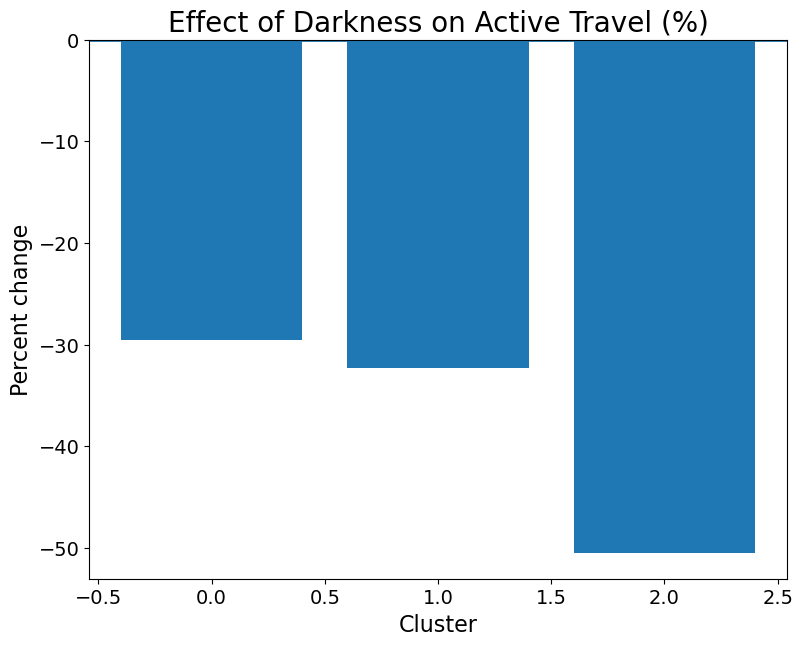

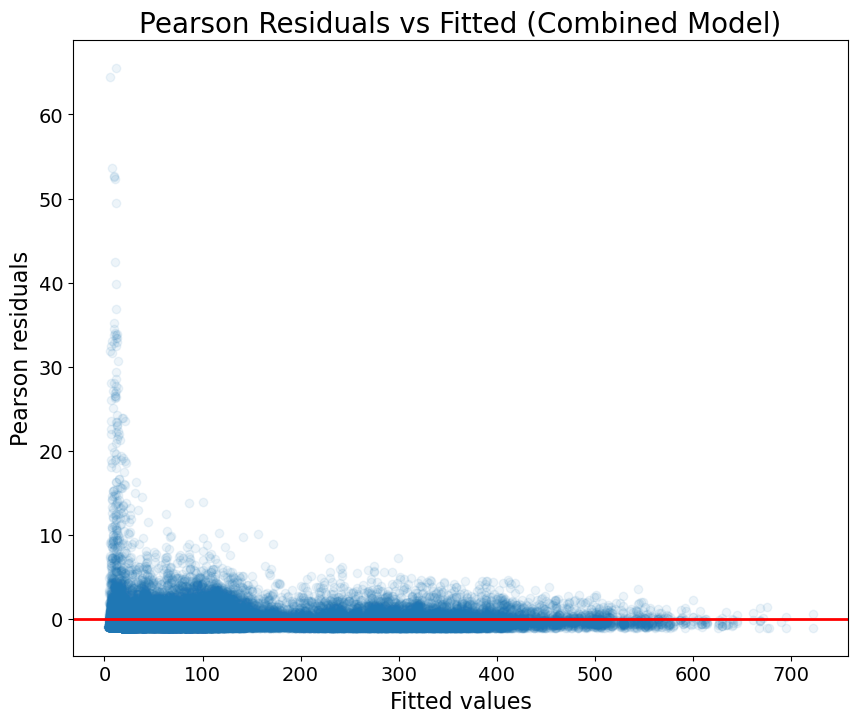

<Figure size 1000x700 with 0 Axes>

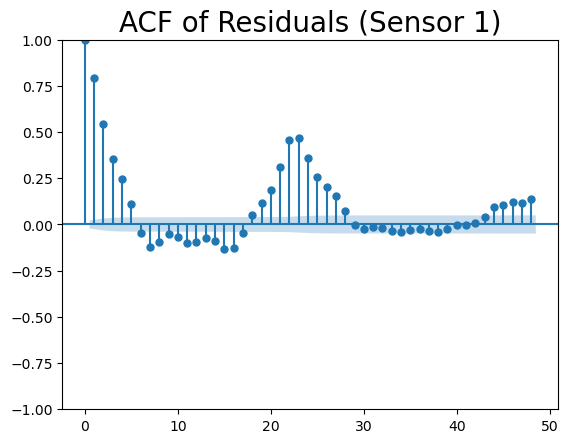

Graphs saved to figures folder.


In [5]:
FIG_DIR = "../figures"

def savefig(name):
    plt.savefig(f"{FIG_DIR}/{name}.png", dpi=220, bbox_inches="tight")
    plt.savefig(f"{FIG_DIR}/{name}.pdf", bbox_inches="tight")

# -----------------------------
# 1) Darkness effect bar chart
# -----------------------------
clusters = sorted(df["cluster_geo"].unique())
effects = [-29.55, -32.26, -50.52]  # replace with computed list if needed

plt.figure(figsize=(9,7))
plt.bar(clusters, effects)
plt.axhline(0, linewidth=2)
plt.title("Effect of Darkness on Active Travel (%)", fontsize=20)
plt.xlabel("Cluster", fontsize=16)
plt.ylabel("Percent change", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
savefig("darkness_effect_active_combined")
plt.show()

# -----------------------------
# 2) Residuals vs fitted
# -----------------------------
mu = model.fittedvalues
res = model.resid_pearson

sample = np.random.choice(len(mu), size=40000, replace=False)

plt.figure(figsize=(10,8))
plt.scatter(mu.iloc[sample], res.iloc[sample], alpha=0.08)
plt.axhline(0, color="red", linewidth=2)
plt.title("Pearson Residuals vs Fitted (Combined Model)", fontsize=20)
plt.xlabel("Fitted values", fontsize=16)
plt.ylabel("Pearson residuals", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
savefig("residuals_vs_fitted_active_combined")
plt.show()

# -----------------------------
# 3) ACF for one sensor
# -----------------------------
sensor_example = df["sensor_id"].iloc[0]
res_s = res[df["sensor_id"] == sensor_example]

plt.figure(figsize=(10,7))
plot_acf(res_s, lags=48)
plt.title(f"ACF of Residuals (Sensor {sensor_example})", fontsize=20)
savefig("acf_residuals_active_combined")
plt.show()

print("Graphs saved to figures folder.")